In [1]:
# https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a
# https://github.com/pourya-ir/Medium/blob/master/Time%20Series%20Machine%20Learning%20Regression%20Framework.ipynb

# This notebook shows model including impact

# Model with parameters: model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.svm import SVR

from sklearn import base

import warnings
warnings.filterwarnings('ignore')

# Data Prep

In [2]:
df = pd.read_csv('041822_final_data.csv')

# TRDTYPE: 1 - Export, 2 - Import
# DISAGMOT: 1 - Truck, 2 - Air
# COUNTRY: 1 - Canada, 2 - Mexico
df_filtered = df[(df['TRDTYPE'] == 2) & (df['DISAGMOT'] == 1) & (df['COUNTRY'] == 1)].copy()


df_filtered = df_filtered.drop(columns=['TRDTYPE','DISAGMOT','COUNTRY','MONTH','YEAR'])
df_filtered = df_filtered.reset_index().drop(columns= 'index')
df_filtered['VALUE'] = df_filtered['VALUE']/df_filtered['VALUE'].max()
df_filtered['impact'] = df_filtered['impact']/df_filtered['impact'].max()
df_filtered

,USASTATE,month_seq,impact,VALUE
0,2,0,1.812694e-03,0.005562
1,1,0,4.840626e-05,0.024734
2,5,0,1.777380e-03,0.019671
3,4,0,9.852190e-04,0.015062
4,6,0,9.845423e-04,0.217410
...,...,...,...,...
5860,50,114,0.000000e+00,0.032248
5861,53,114,1.925276e-07,0.138618
5862,55,114,0.000000e+00,0.071326
5863,54,114,0.000000e+00,0.020216


# To Supervised

In [3]:
class ToSupervised(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        """ Add previous numLags months VALUE to training/test data
        """
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_prev_months'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [4]:
class ToSupervisedDiff(base.BaseEstimator,base.TransformerMixin):
    
    def __init__(self,col,groupCol,numLags,dropna=False):
        """ Add previous difference in numLags months VALUE and current month VALUE to training/test data
        """
        
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self,X,y=None):
        self.X = X
        return self
    
    def transform(self,X):
        tmp = self.X.copy()
        for i in range(1,self.numLags+1):
            tmp[str(i)+'_prev_months_diff_'+"_"+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

# Time Series K-Fold

In [5]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        """ Implement k-folds cross-validation with training data using a rolling window sampling sequence
            and testing using original sequence
        """
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.date_col==None )| (self.date_init==None ) | (self.date_final==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self,X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init,self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self,X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

# Metric: RMSLE

In [6]:
def rmsle(ytrue, ypred):
    """ Returns RMSLE of actual vs predicted VALUE
    """
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

# Baseline Estimator

In [7]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the VALUE last month and this month are the same
            Input: 
                    predCol: l-month ago VALUE
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y,scoring):
        
        prediction = self.predict(X)
    
        error =scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error 

# Time Series Regression

In [8]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        """ Time-series regression of over k-folds, no scaling
        """
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring 
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [9]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        """ Time-series regression of over k-folds, log scaling of target in training
        """
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

# Steps Tuning

In [10]:
def getDataFramePipeline(i):
    """ Helper function to create step tuning pipleine
    """
    steps = [(str(i)+'_step_1',ToSupervised('VALUE','USASTATE',i)),
             (str(i)+'_step_2',ToSupervised('impact','USASTATE',i))]
    for j in range(1,i+1):
        if i==j:

            pp1 = (str(j)+'_step_diff_1',
                  ToSupervisedDiff(str(i)+'_prev_months_VALUE','USASTATE',1,dropna=True))
            steps.append(pp1)
            pp2 = (str(j)+'_step_diff_2',
                  ToSupervisedDiff(str(i)+'_prev_months_impact','USASTATE',1,dropna=True))
            steps.append(pp2)
        else:

            pp1 = (str(j)+'_step_diff_1',
                  ToSupervisedDiff(str(i)+'_prev_months_VALUE','USASTATE',1))
            steps.append(pp1)
            pp2 = (str(j)+'_step_diff_2',
                  ToSupervisedDiff(str(i)+'_prev_months_impact','USASTATE',1))
            steps.append(pp2)
            
    return steps

In [11]:
from tqdm import tqdm
def stepsTune(X,model,num_steps,init=1):
    """ Gather scores when varing number of lags in time series
    """
    scores = []
    for i in tqdm(range(init,num_steps+1)):
        steps = []
        steps.extend(getDataFramePipeline(i))
        steps.append(('predic_1',model))
        super_ = Pipeline(steps).fit(X)
        score_ = np.mean(super_.score(X))
        scores.append((i,score_))
        
    return scores

# State impact Distribution

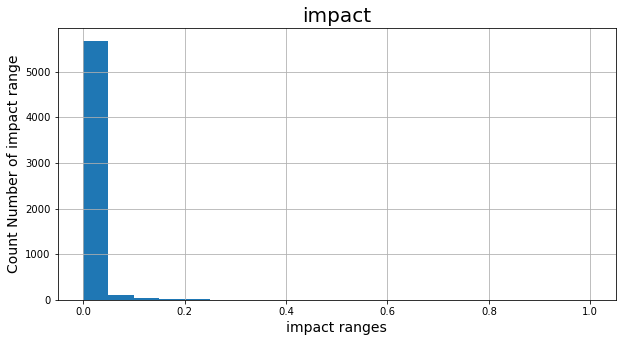

In [14]:
df_filtered['impact'].hist(bins=20, figsize=(10,5))
plt.xlabel('impact ranges',fontsize=14)
plt.ylabel('Count Number of impact range',fontsize=14)
plt.title('impact',fontsize=20)
plt.show()

# Data Prep

In [15]:
steps = [('1_step_1',ToSupervised('VALUE','USASTATE',1)),
         ('1_step_2',ToSupervised('impact','USASTATE',1)),
         ('1_step_diff_1',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1,dropna=True)),
         ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(df_filtered)
super_1.head()

,USASTATE,month_seq,impact,VALUE,1_prev_months_VALUE,1_prev_months_impact,1_prev_months_diff__1_prev_months_VALUE,1_prev_months_diff__1_prev_months_impact
0,2,3,0.000003,0.006982,0.007090,0.000621,0.000062,0.000524
1,1,3,0.000284,0.028797,0.029417,0.000025,-0.000306,-0.000275
2,5,3,0.000955,0.012663,0.013561,0.000911,-0.005679,0.000643
3,4,3,0.000334,0.017482,0.013500,0.000083,-0.000881,0.000044
4,6,3,0.003863,0.173340,0.252416,0.100708,0.083098,0.098844


# First Model - One Step

In [16]:
kf_train = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=50,date_final=75)
model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

In [17]:
steps_1 = [('1_step_1',ToSupervised('VALUE','USASTATE',1)),
           ('1_step_2',ToSupervised('impact','USASTATE',1)),
         ('1_step_diff_1',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1,dropna=True)),
           ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1,dropna=True)),
         ('predic_1',TimeSeriesRegressor(model=model,cv=kf_train,scoring=rmsle))]
super_1_p = Pipeline(steps_1).fit(df_filtered)

In [18]:
Model_1_Error = super_1_p.score(df_filtered)

Fold: 0, Error: 0.0718
Fold: 1, Error: 0.0808
Fold: 2, Error: 0.0782
Fold: 3, Error: 0.0694
Fold: 4, Error: 0.0725
Fold: 5, Error: 0.0669
Fold: 6, Error: 0.0646
Fold: 7, Error: 0.0771
Fold: 8, Error: 0.0701
Fold: 9, Error: 0.0687
Fold: 10, Error: 0.0896
Fold: 11, Error: 0.0713
Fold: 12, Error: 0.0769
Fold: 13, Error: 0.0788
Fold: 14, Error: 0.0821
Fold: 15, Error: 0.0745
Fold: 16, Error: 0.0726
Fold: 17, Error: 0.0755
Fold: 18, Error: 0.0793
Fold: 19, Error: 0.0840
Fold: 20, Error: 0.0771
Fold: 21, Error: 0.0822
Fold: 22, Error: 0.0868
Fold: 23, Error: 0.0658
Fold: 24, Error: 0.0856
Total Error 0.0761


# Second Model - Four Steps

In [19]:
kf_train = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=50,date_final=75)
model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

In [20]:
steps_3 = [('1_step_1',ToSupervised('VALUE','USASTATE',3)),
           ('1_step_2',ToSupervised('impact','USASTATE',3)),
         ('1_step_diff',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1)),
         ('2_step_diff',ToSupervisedDiff('2_prev_months_VALUE','USASTATE',1)),
         ('3_step_diff',ToSupervisedDiff('3_prev_months_VALUE','USASTATE',1,dropna=True)),
           ('1_step_diff_2',ToSupervisedDiff('1_prev_months_impact','USASTATE',1)),
         ('2_step_diff_2',ToSupervisedDiff('2_prev_months_impact','USASTATE',1)),
         ('3_step_diff_3',ToSupervisedDiff('3_prev_months_impact','USASTATE',1,dropna=True)),
         ('predic_3',TimeSeriesRegressor(model=model,cv=kf_train,scoring=rmsle))]
super_3_p = Pipeline(steps_3).fit(df_filtered)

In [21]:
Model_3_Error = super_3_p.score(df_filtered)

Fold: 0, Error: 0.0448
Fold: 1, Error: 0.0534
Fold: 2, Error: 0.0528
Fold: 3, Error: 0.0448
Fold: 4, Error: 0.0453
Fold: 5, Error: 0.0418
Fold: 6, Error: 0.0408
Fold: 7, Error: 0.0522
Fold: 8, Error: 0.0474
Fold: 9, Error: 0.0451
Fold: 10, Error: 0.0634
Fold: 11, Error: 0.0494
Fold: 12, Error: 0.0506
Fold: 13, Error: 0.0514
Fold: 14, Error: 0.0563
Fold: 15, Error: 0.0482
Fold: 16, Error: 0.0454
Fold: 17, Error: 0.0479
Fold: 18, Error: 0.0535
Fold: 19, Error: 0.0583
Fold: 20, Error: 0.0515
Fold: 21, Error: 0.0543
Fold: 22, Error: 0.0588
Fold: 23, Error: 0.0410
Fold: 24, Error: 0.0552
Total Error 0.0502


# Change Target Distribution

In [22]:
kf_train = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=50,date_final=75)
model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

In [23]:
steps_3_log = [('1_step',ToSupervised('VALUE','USASTATE',3)),
         ('1_step_diff',ToSupervisedDiff('1_prev_months_VALUE','USASTATE',1)),
         ('2_step_diff',ToSupervisedDiff('2_prev_months_VALUE','USASTATE',1)),
         ('3_step_diff',ToSupervisedDiff('3_prev_months_VALUE','USASTATE',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model,cv=kf_train,scoring=rmsle))]
super_3_p_log = Pipeline(steps_3_log).fit(df_filtered)

In [24]:
Model_3_Log_Error = super_3_p_log.score(df_filtered)

Fold: 0, Error: 0.0417
Fold: 1, Error: 0.0495
Fold: 2, Error: 0.0490
Fold: 3, Error: 0.0414
Fold: 4, Error: 0.0414
Fold: 5, Error: 0.0387
Fold: 6, Error: 0.0385
Fold: 7, Error: 0.0499
Fold: 8, Error: 0.0450
Fold: 9, Error: 0.0431
Fold: 10, Error: 0.0610
Fold: 11, Error: 0.0475
Fold: 12, Error: 0.0480
Fold: 13, Error: 0.0483
Fold: 14, Error: 0.0532
Fold: 15, Error: 0.0443
Fold: 16, Error: 0.0418
Fold: 17, Error: 0.0445
Fold: 18, Error: 0.0499
Fold: 19, Error: 0.0545
Fold: 20, Error: 0.0474
Fold: 21, Error: 0.0502
Fold: 22, Error: 0.0539
Fold: 23, Error: 0.0377
Fold: 24, Error: 0.0509
Total Error 0.0468


# Tuning Number of Steps

In [25]:
kf_train = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=50,date_final=75)
model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

In [26]:
list_scores2 = stepsTune(df_filtered,
                         TimeSeriesRegressorLog(model=model,scoring=rmsle,
                                             cv=kf_train,verbosity=False),18)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [06:36<00:00, 22.04s/it]


Text(0.5, 1.0, 'Steps Tuning')

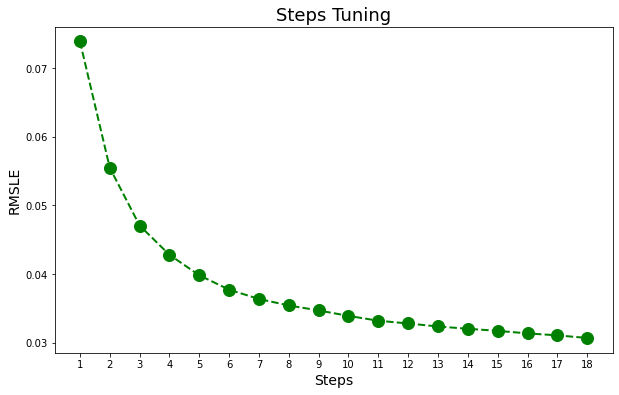

In [27]:
plt.figure(figsize=(10,6))
x = [i[0] for i in list_scores2]
y = [i[1] for i in list_scores2]
plt.plot(x,y,color='green', marker='o', linestyle='dashed',
        linewidth=2, markersize=12)
plt.xticks(np.arange(1, 19, step=1))
plt.xlabel('Steps',fontsize=14)
plt.ylabel('RMSLE',fontsize=14)
plt.title('Steps Tuning',fontsize=18)

# Prediction v Actual Value

In [28]:
kf_test = Kfold_time(target='VALUE',date_col = 'month_seq',date_init=112,date_final=115)
model = SVR(kernel= 'rbf',C= 2.4,epsilon= .0348,shrinking=False,cache_size = 8000)

In [29]:
steps_14 = getDataFramePipeline(14)
super_14 = Pipeline(steps_14).fit_transform(df_filtered)

In [30]:
T_test = TimeSeriesRegressorLog(model=model ,scoring=rmsle,
                                             cv=kf_test,verbosity=False)
T_test.fit(super_14)
prediction = T_test.predict(super_14)

In [31]:
prediction.head()

,0_fold,1_fold,2_fold
0,0.039184,0.039570,0.041084
1,0.067550,0.067261,0.067717
2,0.044668,0.044717,0.045509
3,0.050642,0.050824,0.052454
4,0.188994,0.184470,0.189721


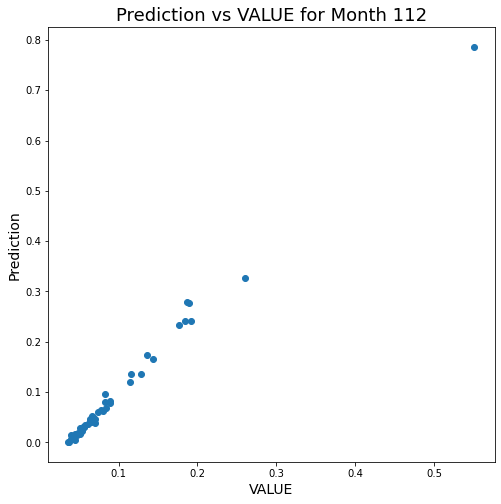

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(prediction['0_fold'],df_filtered[df_filtered['month_seq']==112]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Month 112',fontsize=18)
plt.show()

In [33]:
x = 0
sum_diff = 0
for i in list(prediction['0_fold']):
    sum_diff += abs(i-list(df_filtered[df_filtered['month_seq']==112]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction['0_fold'])
mae

0.033202481098988094

In [34]:
x = 0
sum_diff_sq = 0
for i in list(prediction['0_fold']):
    sum_diff_sq += (i-list(df_filtered[df_filtered['month_seq']==112]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction['0_fold']))**.5
rmse

0.04724587204557478

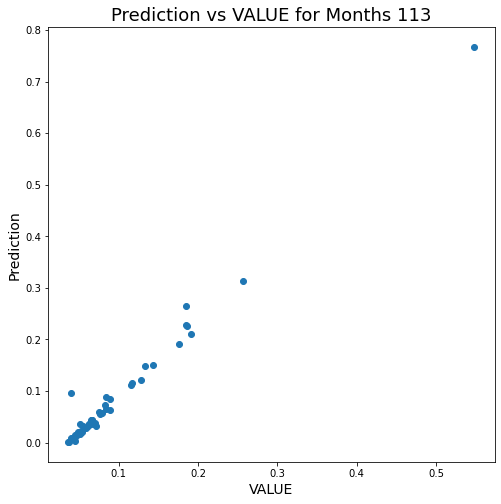

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(prediction['1_fold'],df_filtered[df_filtered['month_seq']==113]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Months 113',fontsize=18)
plt.show()

In [36]:
x = 0
sum_diff = 0
for i in list(prediction['1_fold']):
    sum_diff += abs(i-list(df_filtered[df_filtered['month_seq']==113]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction['1_fold'])
mae

0.031083283286625792

In [37]:
x = 0
sum_diff_sq = 0
for i in list(prediction['1_fold']):
    sum_diff_sq += (i-list(df_filtered[df_filtered['month_seq']==113]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction['1_fold']))**.5
rmse

0.043351874944512425

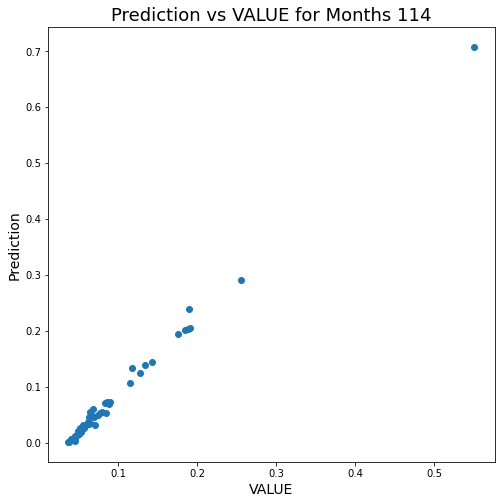

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(prediction['2_fold'],df_filtered[df_filtered['month_seq']==114]['VALUE'])
plt.xlabel('VALUE',fontsize=14)
plt.ylabel('Prediction',fontsize=14)

plt.title('Prediction vs VALUE for Months 114',fontsize=18)
plt.show()

In [39]:
x = 0
sum_diff = 0
for i in list(prediction['2_fold']):
    sum_diff += abs(i-list(df_filtered[df_filtered['month_seq']==114]['VALUE'])[x])
    x+=1
mae = sum_diff/len(prediction['2_fold'])
mae

0.028098101835805335

In [40]:
x = 0
sum_diff_sq = 0
for i in list(prediction['2_fold']):
    sum_diff_sq += (i-list(df_filtered[df_filtered['month_seq']==114]['VALUE'])[x])**2
    x+=1
rmse = (sum_diff_sq/len(prediction['2_fold']))**.5
rmse

0.03530005170231166